<a href="https://colab.research.google.com/github/asante69/Data-Analyst/blob/main/Copy_of_Sentiment_Analysis_and_Model_Testing_Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import your libraries for sentiment analysis

In [2]:
!pip uninstall numpy -y  # Uninstall NumPy
!pip install numpy==1.25.2 # Install a compatible NumPy version.
!pip uninstall gensim -y  # Uninstall Gensim
!pip install gensim==4.3.1 # Reinstall Gensim to match the NumPy version

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 26.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.


Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 47.5 MB/s eta 0:00:00
^C


In [1]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!python -m nltk.downloader punkt
!pip install pandas
!pip install pyLDAvis
!pip install sklearn
!pip install gensim

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned abov

In [32]:
import numpy as np
import datetime as dt
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import string
import re
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import networkx as nx

import gensim
from gensim.utils import simple_preprocess
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Load your scrapped Data

In [33]:
df = pd.read_excel('Health.xlsx')

# Print some info about the concatenated dataframe (optional)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     1414 non-null   object
 1   Comment  1343 non-null   object
dtypes: object(2)
memory usage: 22.2+ KB
None


In [34]:
df.head()

,Date,Comment
0,2025-01-20 11:23:59.995000,CEO David Ricks just made a show of support fo...
1,2025-01-21 11:23:59.995000,NaN
2,2025-01-22 11:23:59.995000,"With Zepbound Not Matching Expectations, Shoul..."
3,2025-01-23 11:23:59.995000,Watch for insider buying in companies with str...
4,2025-01-24 11:23:59.995000,NaN


In [35]:
df.duplicated().sum()

27

In [36]:
df.drop_duplicates(inplace=True)

In [37]:
df.dropna(inplace=True)

##Load Stopwords

In [38]:
# Load stop words
stop_words = stopwords.words('english')

# Show stop words
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

##Perform data cleaning by removing hastags, urls, mentions, symbols, www, pictures, emoji, etc

In [39]:

# Removing hashtags and mentions
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

# Cleaning up the text of the tweets
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_tweet(tweet):
    """
    tweets cleaning by
    1) lowering the case of the tweet,
    2) removing unwanted symbols and replacing them with a whitespace,
    3) split sentences into words according to whitespaces and then
    4) join back with a single whitespace as separator between various words
    """
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r'@[A-Za-z0-9]+', '', str(text)) # remove @mentions
    text = re.sub(r'#', '',  str(text)) # remove the '#' symbol
    text = re.sub(r'RT[\s]+', '',  str(text)) # remove RT
    text = re.sub(r'https?\/\/S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'http\S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'www\S+', '',  str(text)) # remove the www
    text = re.sub(r'pic+', '',  str(text)) # remove the pic
    text = re.sub(r'com', '',  str(text)) # remove the pic
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    #tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

#functions used to remove search terms from all the tweets
#function to remove duplicates from a string - in this case the string is the keywords used to scrape the tweets
def removeDupWithoutOrder(string):
    words = string.lower().split()
    return " ".join(sorted(set(words), key=words.index)).replace('OR', '').replace('  ', ' ')

#function to search for string i.e. remove specific words (search_terms in this case)
def remove_search(text, search_terms):
    query = text.lower()
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in search_terms]
    return ' '.join(resultwords)

# define function to plot frequency of bi-grams, tri-grams, single words, phrases etc
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')

In [40]:
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [41]:
# removing useless content (hashtags, mentions)
df['Comment'].apply(str)

,Comment
0,CEO David Ricks just made a show of support fo...
2,"With Zepbound Not Matching Expectations, Shoul..."
3,Watch for insider buying in companies with str...
5,Watch for insider activity in companies with s...
6,Watch for insider buying before earnings repor...
...,...
1409,invest here
1410,partnership with big pharma very soon. Faron P...
1411,: Buy AbbVie at $177.70 take profits at $190 w...
1412,yall realize this load zone? $200 is going to ...


In [43]:
df['cleaned_comments'] = df['Comment'].astype(str).apply(lambda x: process_tweet(x))

In [44]:
df

,Date,Comment,cleaned_comments
0,2025-01-20 11:23:59.995000,CEO David Ricks just made a show of support fo...,ceo david ricks just made a show of support fo...
2,2025-01-22 11:23:59.995000,"With Zepbound Not Matching Expectations, Shoul...",with zepbound not matching expectations should...
3,2025-01-23 11:23:59.995000,Watch for insider buying in companies with str...,watch for insider buying in companies with str...
5,2025-01-25 11:23:59.995000,Watch for insider activity in companies with s...,watch for insider activity in companies with s...
6,2025-01-26 11:23:59.995000,Watch for insider buying before earnings repor...,watch for insider buying before earnings repor...
...,...,...,...
1409,2025-01-02 04:55:00,invest here,invest here
1410,2025-01-02 04:21:00,partnership with big pharma very soon. Faron P...,partnership with big pharma very soon faron ph...
1411,2025-01-01 17:45:00,: Buy AbbVie at $177.70 take profits at $190 w...,buy abbvie at 177 70 take profits at 190 with ...
1412,2025-01-01 03:49:00,yall realize this load zone? $200 is going to ...,yall realize this load zone 200 is going to be...


###Check the number of comments or reviews in the dataset

In [45]:
df['cleaned_comments'].nunique()

1182

In [46]:
#Save cleaned_comments data
df.to_csv('cleaned_comments.csv', index=False)

In [47]:
df['Comment'] = df['Comment'].str.replace('http\S+', '')


###Generate Word Frequency to analyze the most occuring word within the dataset

In [48]:
from PIL import Image
import urllib
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

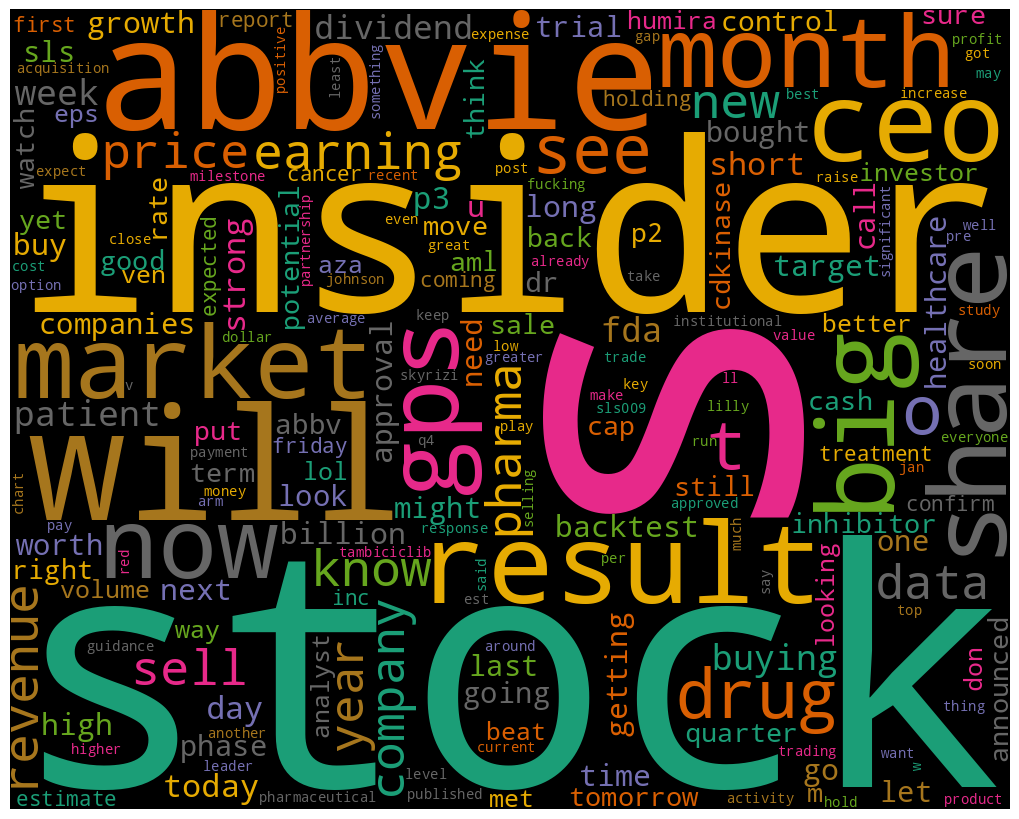

In [49]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.cleaned_comments:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 800,
                background_color='black', colormap='Dark2',
                collocations=False,
                stopwords = stopwords,
                min_font_size = 12).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

###Plot Polarity and Subjectivity Scores

In [52]:
def getSubjectivity(text):
    return TextBlob( str(text)).sentiment.subjectivity

def getPolarity(text):
    return TextBlob( str(text)).sentiment.polarity

In [51]:
df.dropna(subset=['cleaned_comments'], inplace = True)
df.reset_index(drop=True, inplace=True)

In [53]:
df['Subjectivity'] = df['cleaned_comments'].apply(getSubjectivity)
df['Polarity'] = df['cleaned_comments'].apply(getPolarity)
df.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity
0,2025-01-20 11:23:59.995000,CEO David Ricks just made a show of support fo...,ceo david ricks just made a show of support fo...,0.447222,0.158333
1,2025-01-22 11:23:59.995000,"With Zepbound Not Matching Expectations, Shoul...",with zepbound not matching expectations should...,0.625000,0.191667
2,2025-01-23 11:23:59.995000,Watch for insider buying in companies with str...,watch for insider buying in companies with str...,0.516667,0.216667
3,2025-01-25 11:23:59.995000,Watch for insider activity in companies with s...,watch for insider activity in companies with s...,0.733333,0.433333
4,2025-01-26 11:23:59.995000,Watch for insider buying before earnings repor...,watch for insider buying before earnings repor...,0.600000,0.700000


In [54]:

def get_Polarity_Analysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'
def get_Subjectivity_Analysis(score):
    if score >  0:
      return 'Opinion'
    else:
      return 'Fact'

df['Analysis_Polarity'] = df['Polarity'].apply(get_Polarity_Analysis)

df['Analysis_Subjectivity'] = df['Subjectivity'].apply(get_Subjectivity_Analysis)

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)

###Plot Polarity and Subjectiviy Score in Scatter Plot

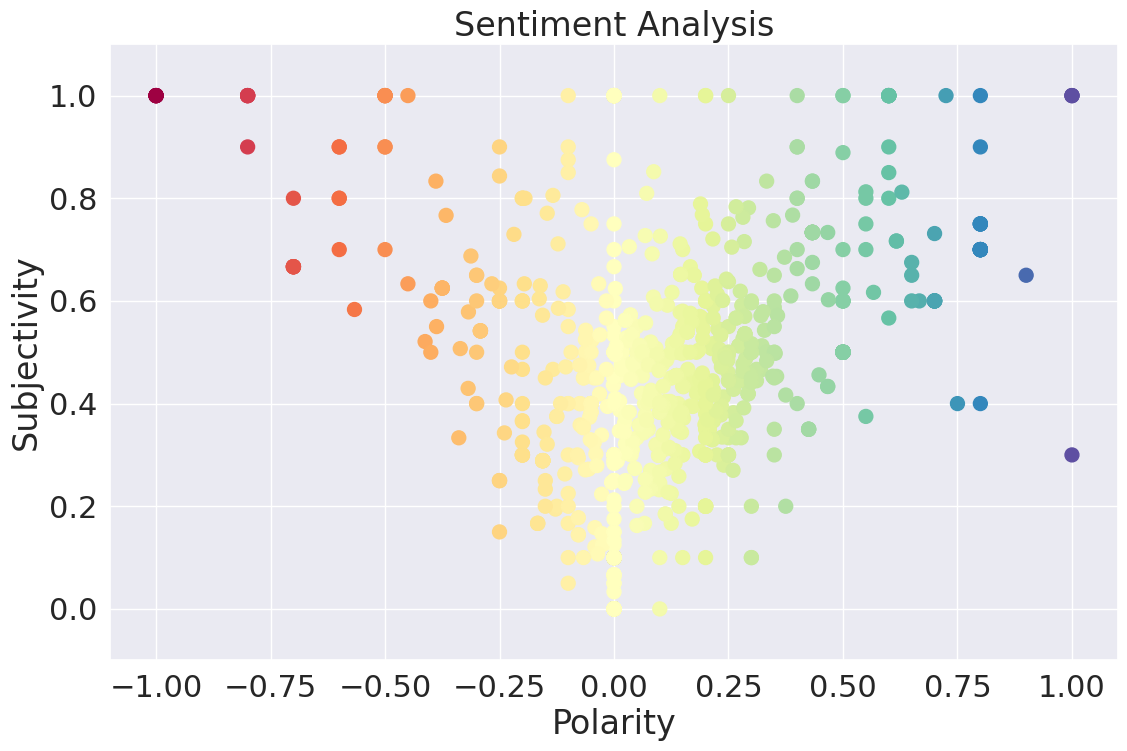

(None,)

In [56]:
plt.figure(figsize=(13,8))

plt.scatter(df['Polarity'], df['Subjectivity'], c=df['Polarity'], s=100, cmap='Spectral')

plt.xlim(-1.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show(),

In [57]:
df['Sentiment'] = df.apply(lambda x: ' '.join([str(x['Analysis_Polarity']),str(x['Analysis_Subjectivity'])]),axis=1)
df.head()


,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,2025-01-20 11:23:59.995000,CEO David Ricks just made a show of support fo...,ceo david ricks just made a show of support fo...,0.447222,0.158333,Positive,Opinion,Positive Opinion
1,2025-01-22 11:23:59.995000,"With Zepbound Not Matching Expectations, Shoul...",with zepbound not matching expectations should...,0.625000,0.191667,Positive,Opinion,Positive Opinion
2,2025-01-23 11:23:59.995000,Watch for insider buying in companies with str...,watch for insider buying in companies with str...,0.516667,0.216667,Positive,Opinion,Positive Opinion
3,2025-01-25 11:23:59.995000,Watch for insider activity in companies with s...,watch for insider activity in companies with s...,0.733333,0.433333,Positive,Opinion,Positive Opinion
4,2025-01-26 11:23:59.995000,Watch for insider buying before earnings repor...,watch for insider buying before earnings repor...,0.600000,0.700000,Positive,Opinion,Positive Opinion


###Plot Polarity Score for the entire dataset using bar chart

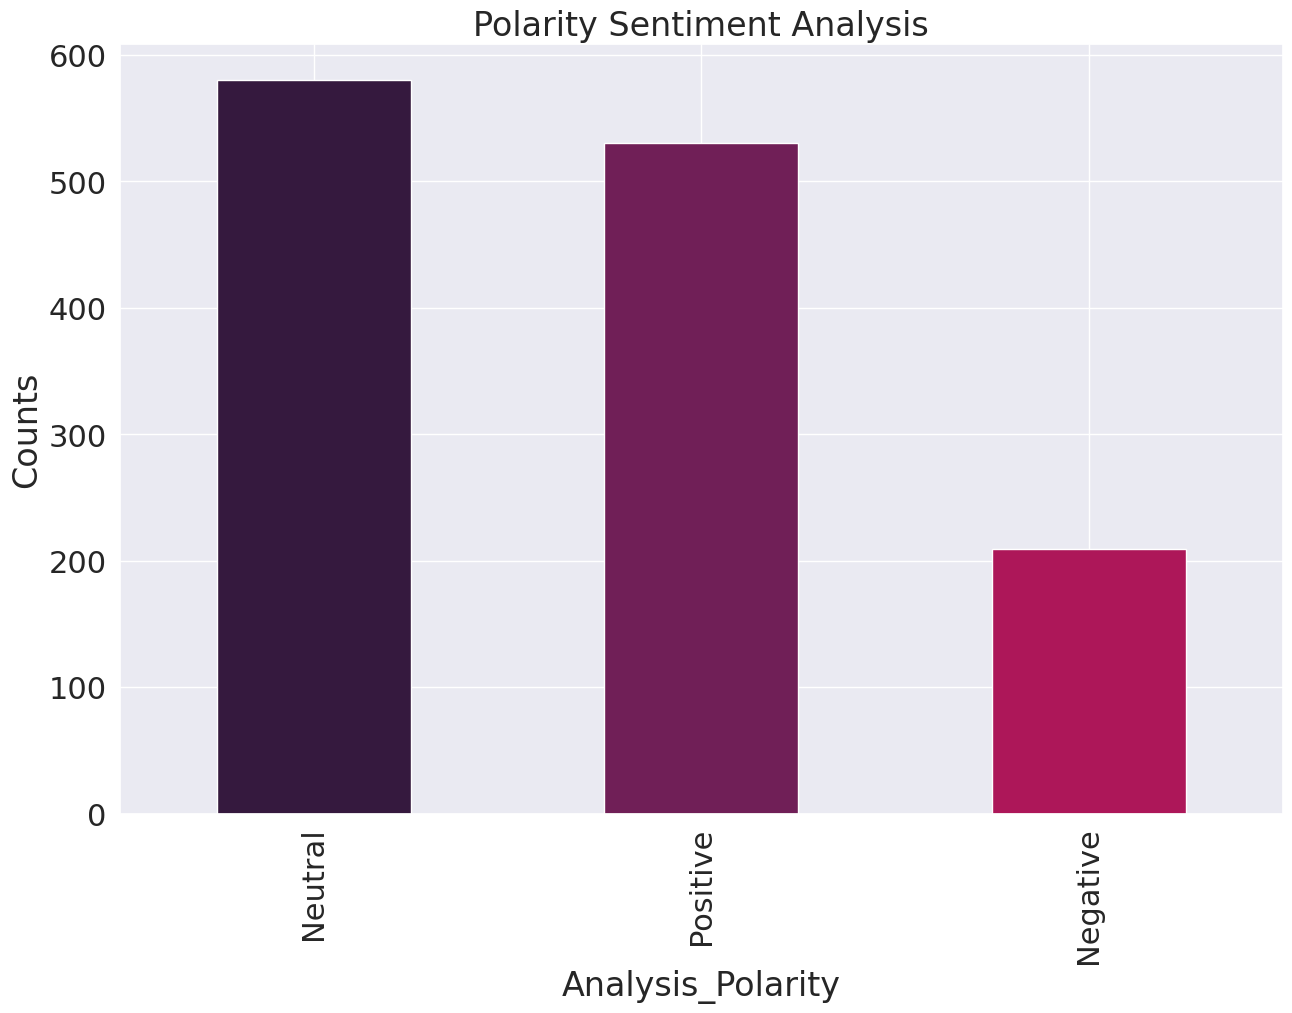

In [58]:

plt.figure(figsize=(15,10))

plt.title('Polarity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Polarity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()

###Plot Subjectivity and Objective

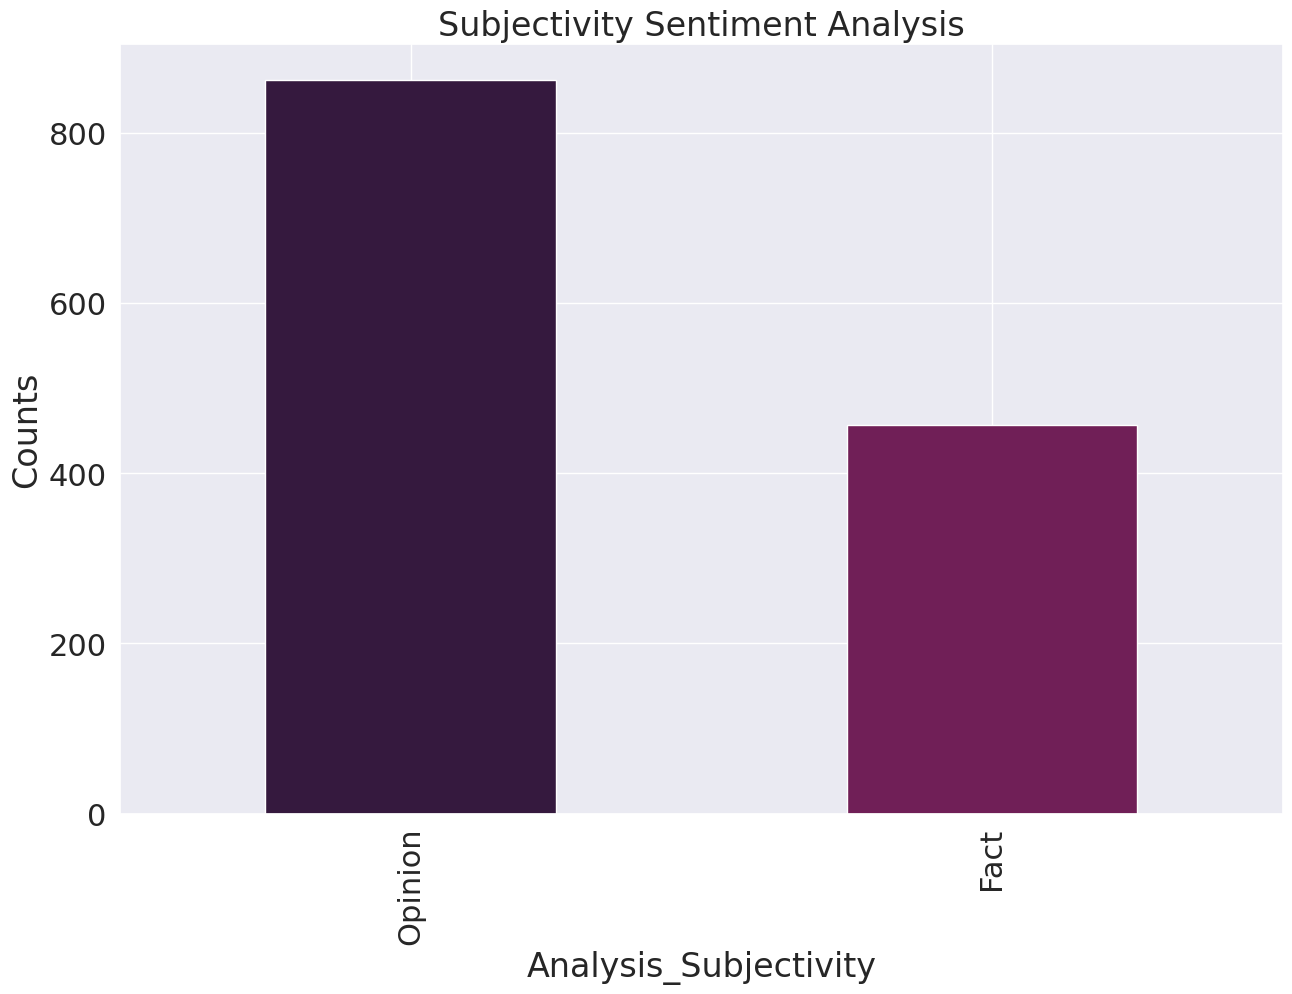

In [59]:
plt.figure(figsize=(15,10))
plt.title('Subjectivity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Subjectivity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()


In [60]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [61]:
!pip install gensim

In [62]:

pyLDAvis.enable_notebook()


In [63]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tf.shape)

(1319, 262)


In [64]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tfidf.shape)

(1319, 262)


In [65]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(random_state=50)

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
import pyLDAvis.lda_model
...
pyLDAvis.lda_model.prepare

<function pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, **kwargs)>

In [68]:
nltk.download('stopwords')
from nltk.corpus import stopwords  # Import the stopwords module

english_stopwords = stopwords.words('english')  # Call words on the module
english_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])

def sentences_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuation.
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in english_stopwords] for doc in texts]

comments = df.cleaned_comments.to_list()
comment_words = list(sentences_to_words(comments))

# Remove stop words.
comment_words = remove_stopwords(comment_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
import gensim.corpora as corpora

# Create Dictionary.
id2word = corpora.Dictionary(comment_words)

# Create Corpus.
texts = comment_words

# Term Document Frequency.
corpus = [id2word.doc2bow(text) for text in texts]

In [70]:
from pprint import pprint

# Number of topics.
num_topics = 10

# Build LDA model.
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics
)

# Print the Keyword in the 10 topics.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.007*"get" + 0.005*"buy" + 0.005*"see" + 0.004*"lol" + 0.004*"new" + '
  '0.004*"data" + 0.004*"study" + 0.003*"good" + 0.003*"move" + 0.003*"going"'),
 (1,
  '0.011*"os" + 0.009*"price" + 0.007*"sls" + 0.007*"months" + '
  '0.006*"inhibitor" + 0.006*"gps" + 0.005*"high" + 0.005*"data" + '
  '0.005*"cdkinase" + 0.005*"dr"'),
 (2,
  '0.007*"see" + 0.007*"stock" + 0.006*"week" + 0.006*"abbvie" + '
  '0.006*"shares" + 0.006*"time" + 0.006*"company" + 0.005*"market" + '
  '0.005*"next" + 0.005*"get"'),
 (3,
  '0.010*"months" + 0.009*"os" + 0.009*"gps" + 0.008*"insider" + 0.007*"know" '
  '+ 0.006*"results" + 0.006*"patients" + 0.006*"earnings" + 0.006*"price" + '
  '0.006*"control"'),
 (4,
  '0.007*"going" + 0.006*"sls" + 0.006*"insider" + 0.006*"day" + '
  '0.005*"revenue" + 0.005*"inhibitor" + 0.005*"strong" + 0.005*"abbvie" + '
  '0.004*"shares" + 0.004*"cdkinase"'),
 (5,
  '0.009*"gps" + 0.008*"market" + 0.007*"fda" + 0.007*"abbvie" + '
  '0.007*"approval" + 0.007*"results" + 

In [82]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

# Visualize the topics.
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(f'cleaned_comments_lda_{num_topics}.data')

if os.path.exists(LDAvis_data_filepath):
    # Load the pre-prepared pyLDAvis data from disk.
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
else:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

pyLDAvis.save_html(LDAvis_prepared, f'{LDAvis_data_filepath}.html')

In [83]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.038373 -0.048721       1        1  16.693200
7      0.076416  0.007307       2        1  11.924259
1      0.073657 -0.021876       3        1  11.402362
3      0.042787 -0.025440       4        1  11.333191
6     -0.011234  0.080582       5        1  11.264466
2     -0.112863 -0.078112       6        1   9.083929
9      0.003397  0.028207       7        1   8.664854
8     -0.074671  0.080091       8        1   7.712110
4      0.017316  0.011534       9        1   6.772172
0     -0.053178 -0.033571      10        1   5.149455, topic_info=        Term       Freq      Total Category  logprob  loglift
275    today  48.000000  48.000000  Default  30.0000  30.0000
166     ceos  32.000000  32.000000  Default  29.0000  29.0000
30     price  61.000000  61.000000  Default  28.0000  28.0000
143   target  36.000000  36.000000  Default  27.0000  27.0000
1258   sells  45.000000  45.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
22    market   2.369781  70.872918  Topic10  -5.8874  -0.4318
369     like   2.229575  46.119831  Topic10  -5.9483  -0.0632
9        ceo   2.139013  64.089005  Topic10  -5.9898  -0.4336
30     price   2.115630  61.565330  Topic10  -6.0008  -0.4045
64    months   2.116978  64.542094  Topic10  -6.0002  -0.4510

[830 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2365      1  0.065970   abbv
2365      2  0.065970   abbv
2365      3  0.032985   abbv
2365      4  0.098956   abbv
2365      5  0.197911   abbv
...     ...       ...    ...
47        7  0.089325  years
47        9  0.044663  years
3179      8  0.829045    yoy
827      10  0.711888  yucky
2599      9  0.657041    yup

[2068 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 2, 4, 7, 3, 10, 9, 5, 1])

In [84]:
topic_values = lda_tf.transform(dtm_tf)
topic_values.shape

(1319, 10)

In [85]:
df.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic
0,2025-01-20 11:23:59.995000,CEO David Ricks just made a show of support fo...,ceo david ricks just made a show of support fo...,0.447222,0.158333,Positive,Opinion,Positive Opinion,5
1,2025-01-22 11:23:59.995000,"With Zepbound Not Matching Expectations, Shoul...",with zepbound not matching expectations should...,0.625000,0.191667,Positive,Opinion,Positive Opinion,0
2,2025-01-23 11:23:59.995000,Watch for insider buying in companies with str...,watch for insider buying in companies with str...,0.516667,0.216667,Positive,Opinion,Positive Opinion,9
3,2025-01-25 11:23:59.995000,Watch for insider activity in companies with s...,watch for insider activity in companies with s...,0.733333,0.433333,Positive,Opinion,Positive Opinion,9
4,2025-01-26 11:23:59.995000,Watch for insider buying before earnings repor...,watch for insider buying before earnings repor...,0.600000,0.700000,Positive,Opinion,Positive Opinion,9


In [95]:
df['Topic'] = topic_values.argmax(axis=1)

In [96]:
df_1=df.replace({0:'General Discussion',1:'Drug Development & Clinlcal Trials',2:'Stock Performance & Company Analysis',3:'Earnings Report',4:'Company Performance',5:'FDA Approval & Drug Market',6:'Company Financials & Growth',7:'Insider Trading',8:'Stock Price & Target Predictions',9:'Stock Recommendations & Market Outlook'})

In [88]:
df_1

,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic
0,2025-01-20 11:23:59.995000,CEO David Ricks just made a show of support fo...,ceo david ricks just made a show of support fo...,0.447222,0.158333,Positive,Opinion,Positive Opinion,FDA Approval & Drug Market
1,2025-01-22 11:23:59.995000,"With Zepbound Not Matching Expectations, Shoul...",with zepbound not matching expectations should...,0.625,0.191667,Positive,Opinion,Positive Opinion,General Discussion
2,2025-01-23 11:23:59.995000,Watch for insider buying in companies with str...,watch for insider buying in companies with str...,0.516667,0.216667,Positive,Opinion,Positive Opinion,Stock Recommendations & Market Outlook
3,2025-01-25 11:23:59.995000,Watch for insider activity in companies with s...,watch for insider activity in companies with s...,0.733333,0.433333,Positive,Opinion,Positive Opinion,Stock Recommendations & Market Outlook
4,2025-01-26 11:23:59.995000,Watch for insider buying before earnings repor...,watch for insider buying before earnings repor...,0.6,0.7,Positive,Opinion,Positive Opinion,Stock Recommendations & Market Outlook
...,...,...,...,...,...,...,...,...,...
1314,2025-01-02 04:55:00,invest here,invest here,General Discussion,General Discussion,Neutral,Fact,Neutral Fact,General Discussion
1315,2025-01-02 04:21:00,partnership with big pharma very soon. Faron P...,partnership with big pharma very soon faron ph...,0.266667,0.1,Positive,Opinion,Positive Opinion,Stock Recommendations & Market Outlook
1316,2025-01-01 17:45:00,: Buy AbbVie at $177.70 take profits at $190 w...,buy abbvie at 177 70 take profits at 190 with ...,0.5,0.166667,Positive,Opinion,Positive Opinion,FDA Approval & Drug Market
1317,2025-01-01 03:49:00,yall realize this load zone? $200 is going to ...,yall realize this load zone 200 is going to be...,0.3,0.2,Positive,Opinion,Positive Opinion,Earnings Report


In [92]:
#df_1['topic'] = topic_values.argmax(axis=1)

In [97]:
df_1.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic
0,2025-01-20 11:23:59.995000,CEO David Ricks just made a show of support fo...,ceo david ricks just made a show of support fo...,0.447222,0.158333,Positive,Opinion,Positive Opinion,FDA Approval & Drug Market
1,2025-01-22 11:23:59.995000,"With Zepbound Not Matching Expectations, Shoul...",with zepbound not matching expectations should...,0.625,0.191667,Positive,Opinion,Positive Opinion,General Discussion
2,2025-01-23 11:23:59.995000,Watch for insider buying in companies with str...,watch for insider buying in companies with str...,0.516667,0.216667,Positive,Opinion,Positive Opinion,Stock Recommendations & Market Outlook
3,2025-01-25 11:23:59.995000,Watch for insider activity in companies with s...,watch for insider activity in companies with s...,0.733333,0.433333,Positive,Opinion,Positive Opinion,Stock Recommendations & Market Outlook
4,2025-01-26 11:23:59.995000,Watch for insider buying before earnings repor...,watch for insider buying before earnings repor...,0.6,0.7,Positive,Opinion,Positive Opinion,Stock Recommendations & Market Outlook


In [98]:
df_1.columns

Index(['Date', 'Comment', 'cleaned_comments', 'Subjectivity', 'Polarity',
       'Analysis_Polarity', 'Analysis_Subjectivity', 'Sentiment', 'Topic'],
      dtype='object')

<Figure size 4000x2500 with 0 Axes>

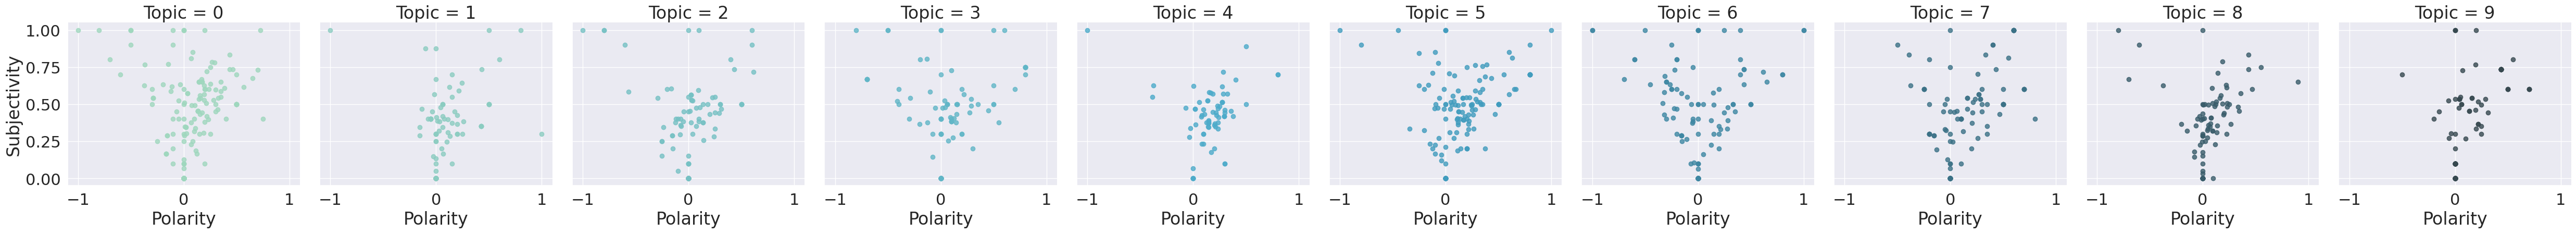

In [99]:
plt.figure(figsize=(40,25))

g=sns.lmplot(x="Polarity", y="Subjectivity", hue='Topic', data=df, fit_reg=False, legend=False,palette="GnBu_d", col='Topic', legend_out=True)


plt.show()

In [100]:
df_2 = df_1.groupby(['Topic'])['Analysis_Polarity'].value_counts().unstack('Topic').transpose()

df_2

Analysis_Polarity,Negative,Neutral,Positive
Topic,,,
Company Financials & Growth,40,65,35
Company Performance,6,6,60
Drug Development & Clinlcal Trials,16,49,44
Earnings Report,20,41,43
FDA Approval & Drug Market,25,24,83
General Discussion,35,186,82
Insider Trading,21,48,52
Stock Performance & Company Analysis,25,51,40
Stock Price & Target Predictions,15,27,46


In [101]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Company Financials & Growth to Stock Recommendations & Market Outlook
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Negative  10 non-null     int64
 1   Neutral   10 non-null     int64
 2   Positive  10 non-null     int64
dtypes: int64(3)
memory usage: 320.0+ bytes


In [102]:
df_2['Total'] = df_2.sum(axis=1)

In [103]:
df_2.columns

Index(['Negative', 'Neutral', 'Positive', 'Total'], dtype='object', name='Analysis_Polarity')

In [104]:
for i in df_2:
    df_2[i] = round(df_2[i]*100/df_2.Total)

df_2

Analysis_Polarity,Negative,Neutral,Positive,Total
Topic,,,,
Company Financials & Growth,29.0,46.0,25.0,100.0
Company Performance,8.0,8.0,83.0,100.0
Drug Development & Clinlcal Trials,15.0,45.0,40.0,100.0
Earnings Report,19.0,39.0,41.0,100.0
FDA Approval & Drug Market,19.0,18.0,63.0,100.0
General Discussion,12.0,61.0,27.0,100.0
Insider Trading,17.0,40.0,43.0,100.0
Stock Performance & Company Analysis,22.0,44.0,34.0,100.0
Stock Price & Target Predictions,17.0,31.0,52.0,100.0


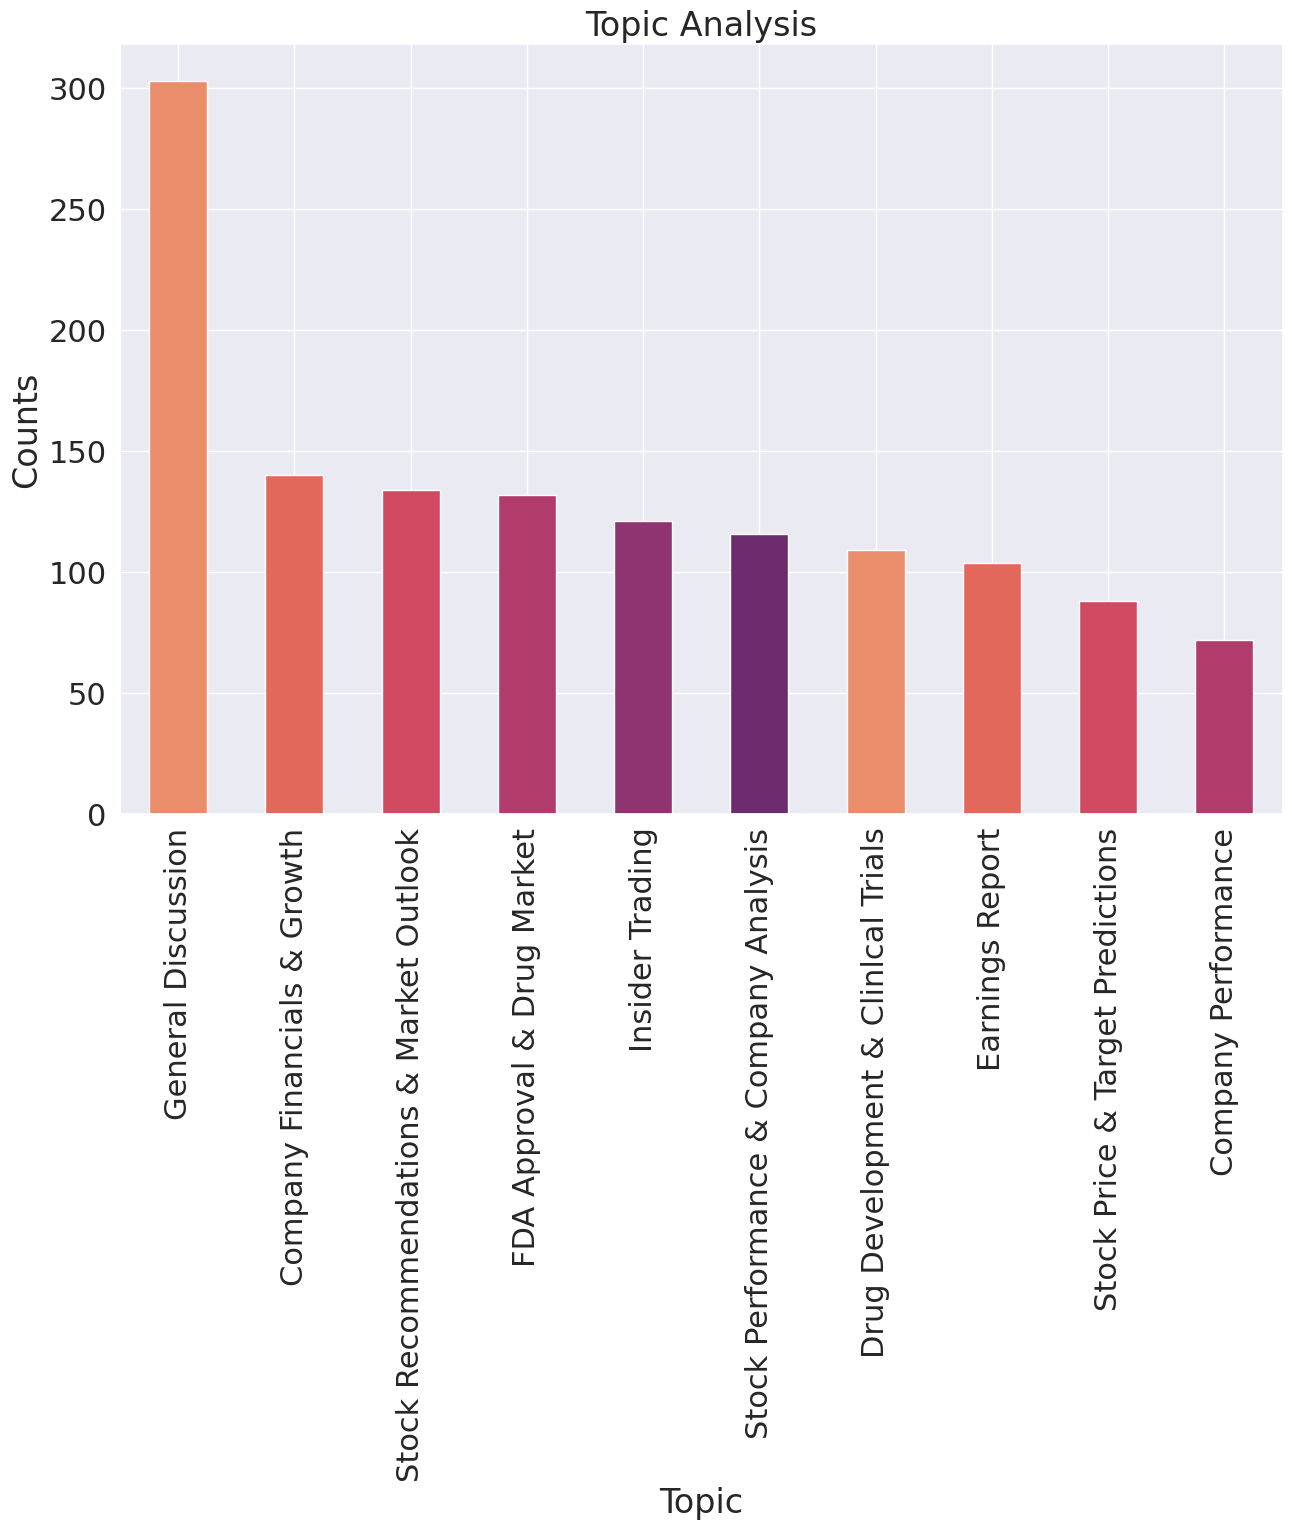

In [105]:
# Plot and visualizing the counts for each topic
plt.figure(figsize=(15,10))

plt.title('Topic Analysis')
plt.xlabel('Topic')
plt.ylabel('Counts')
df_1['Topic'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('flare'))
plt.show()


In [106]:
df_2=df_2.fillna(0)

In [107]:
df_2['Total'] = df_2.sum(axis=1)
df_2 = df_2.drop(['Total'], axis=1)

In [108]:
print(df_2.shape)

(10, 3)


In [109]:
print(df_2.head())

Analysis_Polarity                   Negative  Neutral  Positive
Topic                                                          
Company Financials & Growth             29.0     46.0      25.0
Company Performance                      8.0      8.0      83.0
Drug Development & Clinlcal Trials      15.0     45.0      40.0
Earnings Report                         19.0     39.0      41.0
FDA Approval & Drug Market              19.0     18.0      63.0


In [110]:
print(df_2.tail())

Analysis_Polarity                       Negative  Neutral  Positive
Topic                                                              
General Discussion                          12.0     61.0      27.0
Insider Trading                             17.0     40.0      43.0
Stock Performance & Company Analysis        22.0     44.0      34.0
Stock Price & Target Predictions            17.0     31.0      52.0
Stock Recommendations & Market Outlook       4.0     62.0      34.0


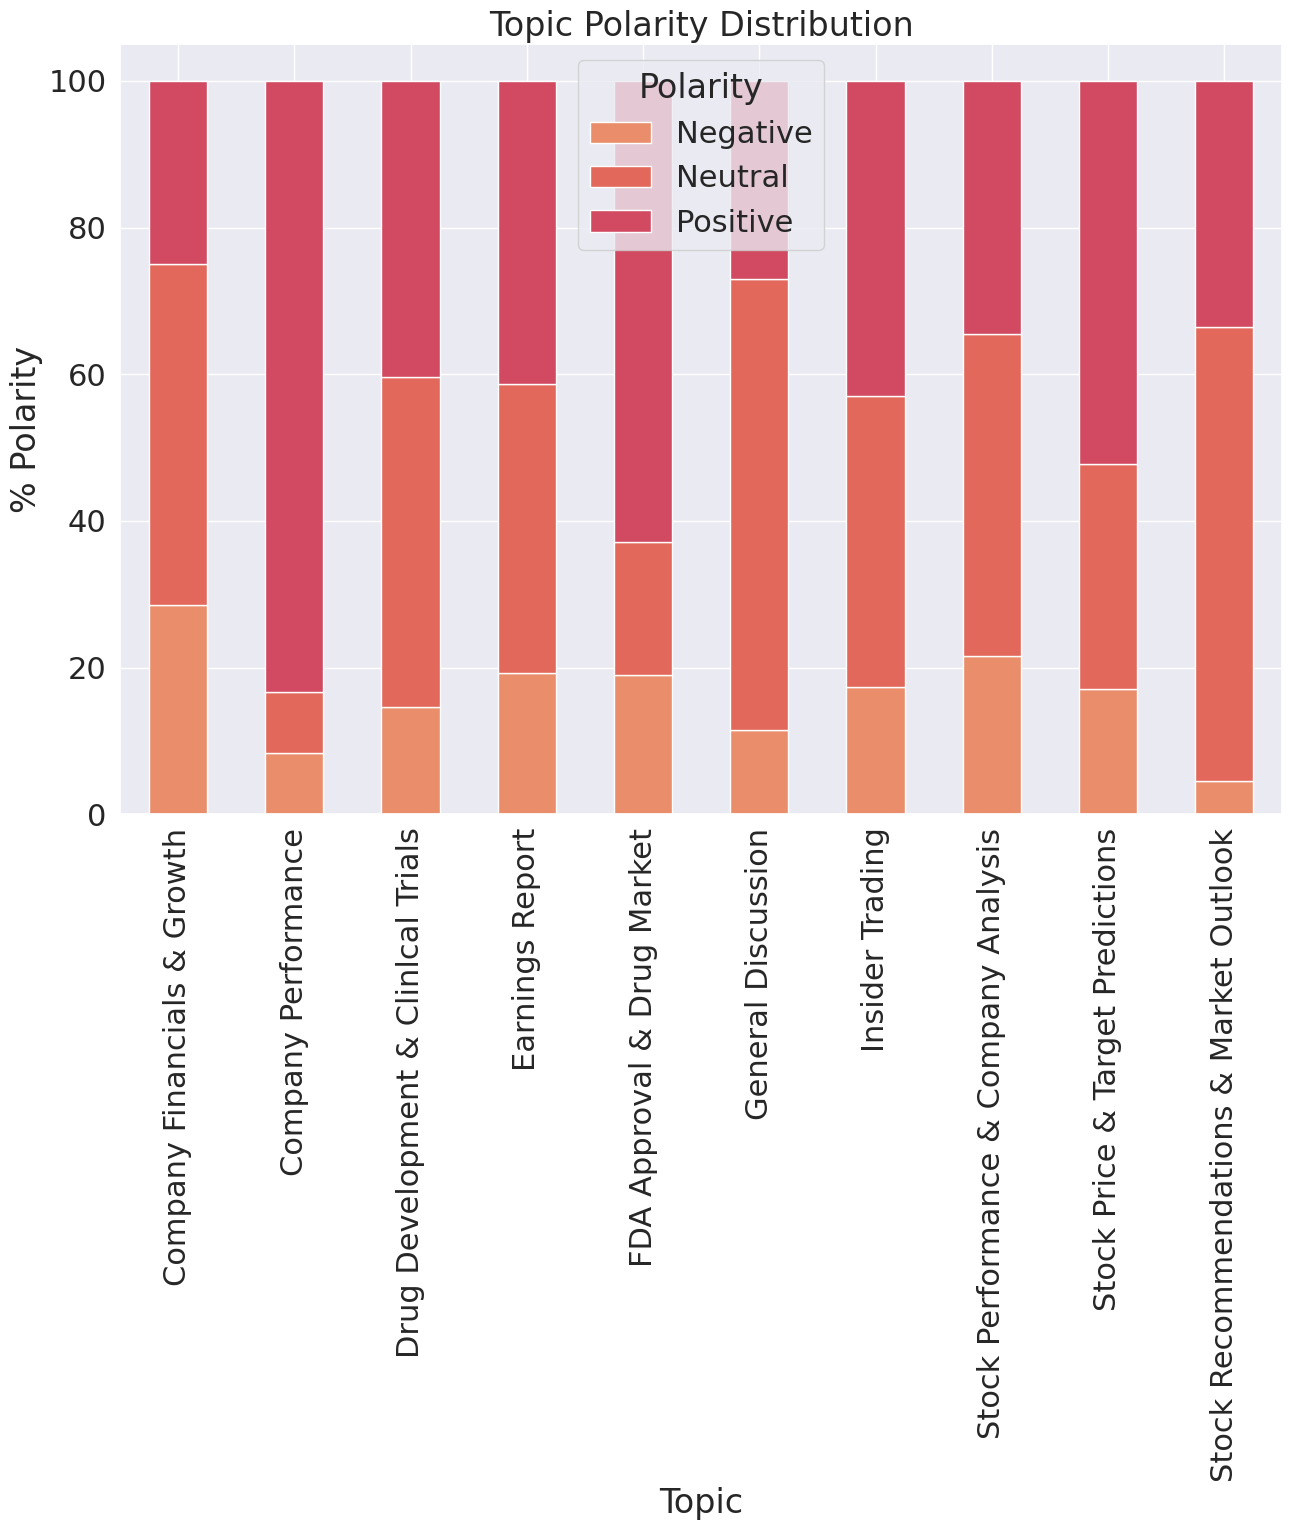

In [111]:
# Create a new dataframe with topic names and polarity percentages
df_topic_polarity = df_1.groupby('Topic')['Analysis_Polarity'].value_counts().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

# Create the stacked bar plot
ax = df_topic_polarity.plot(kind='bar',color=sns.palettes.mpl_palette('flare'), stacked=True, figsize=(15, 10))

# Add labels and title
ax.set_xlabel('Topic')
ax.set_ylabel('% Polarity')
ax.set_title('Topic Polarity Distribution')

# Add topic names to the x-axis
ax.set_xticklabels(df_topic_polarity.index, rotation=90)

# Add legend
ax.legend(title='Polarity')

# Show the plot
plt.show()


###Perform Topic Labeling to analyze the polarity score of each of the topics identified.

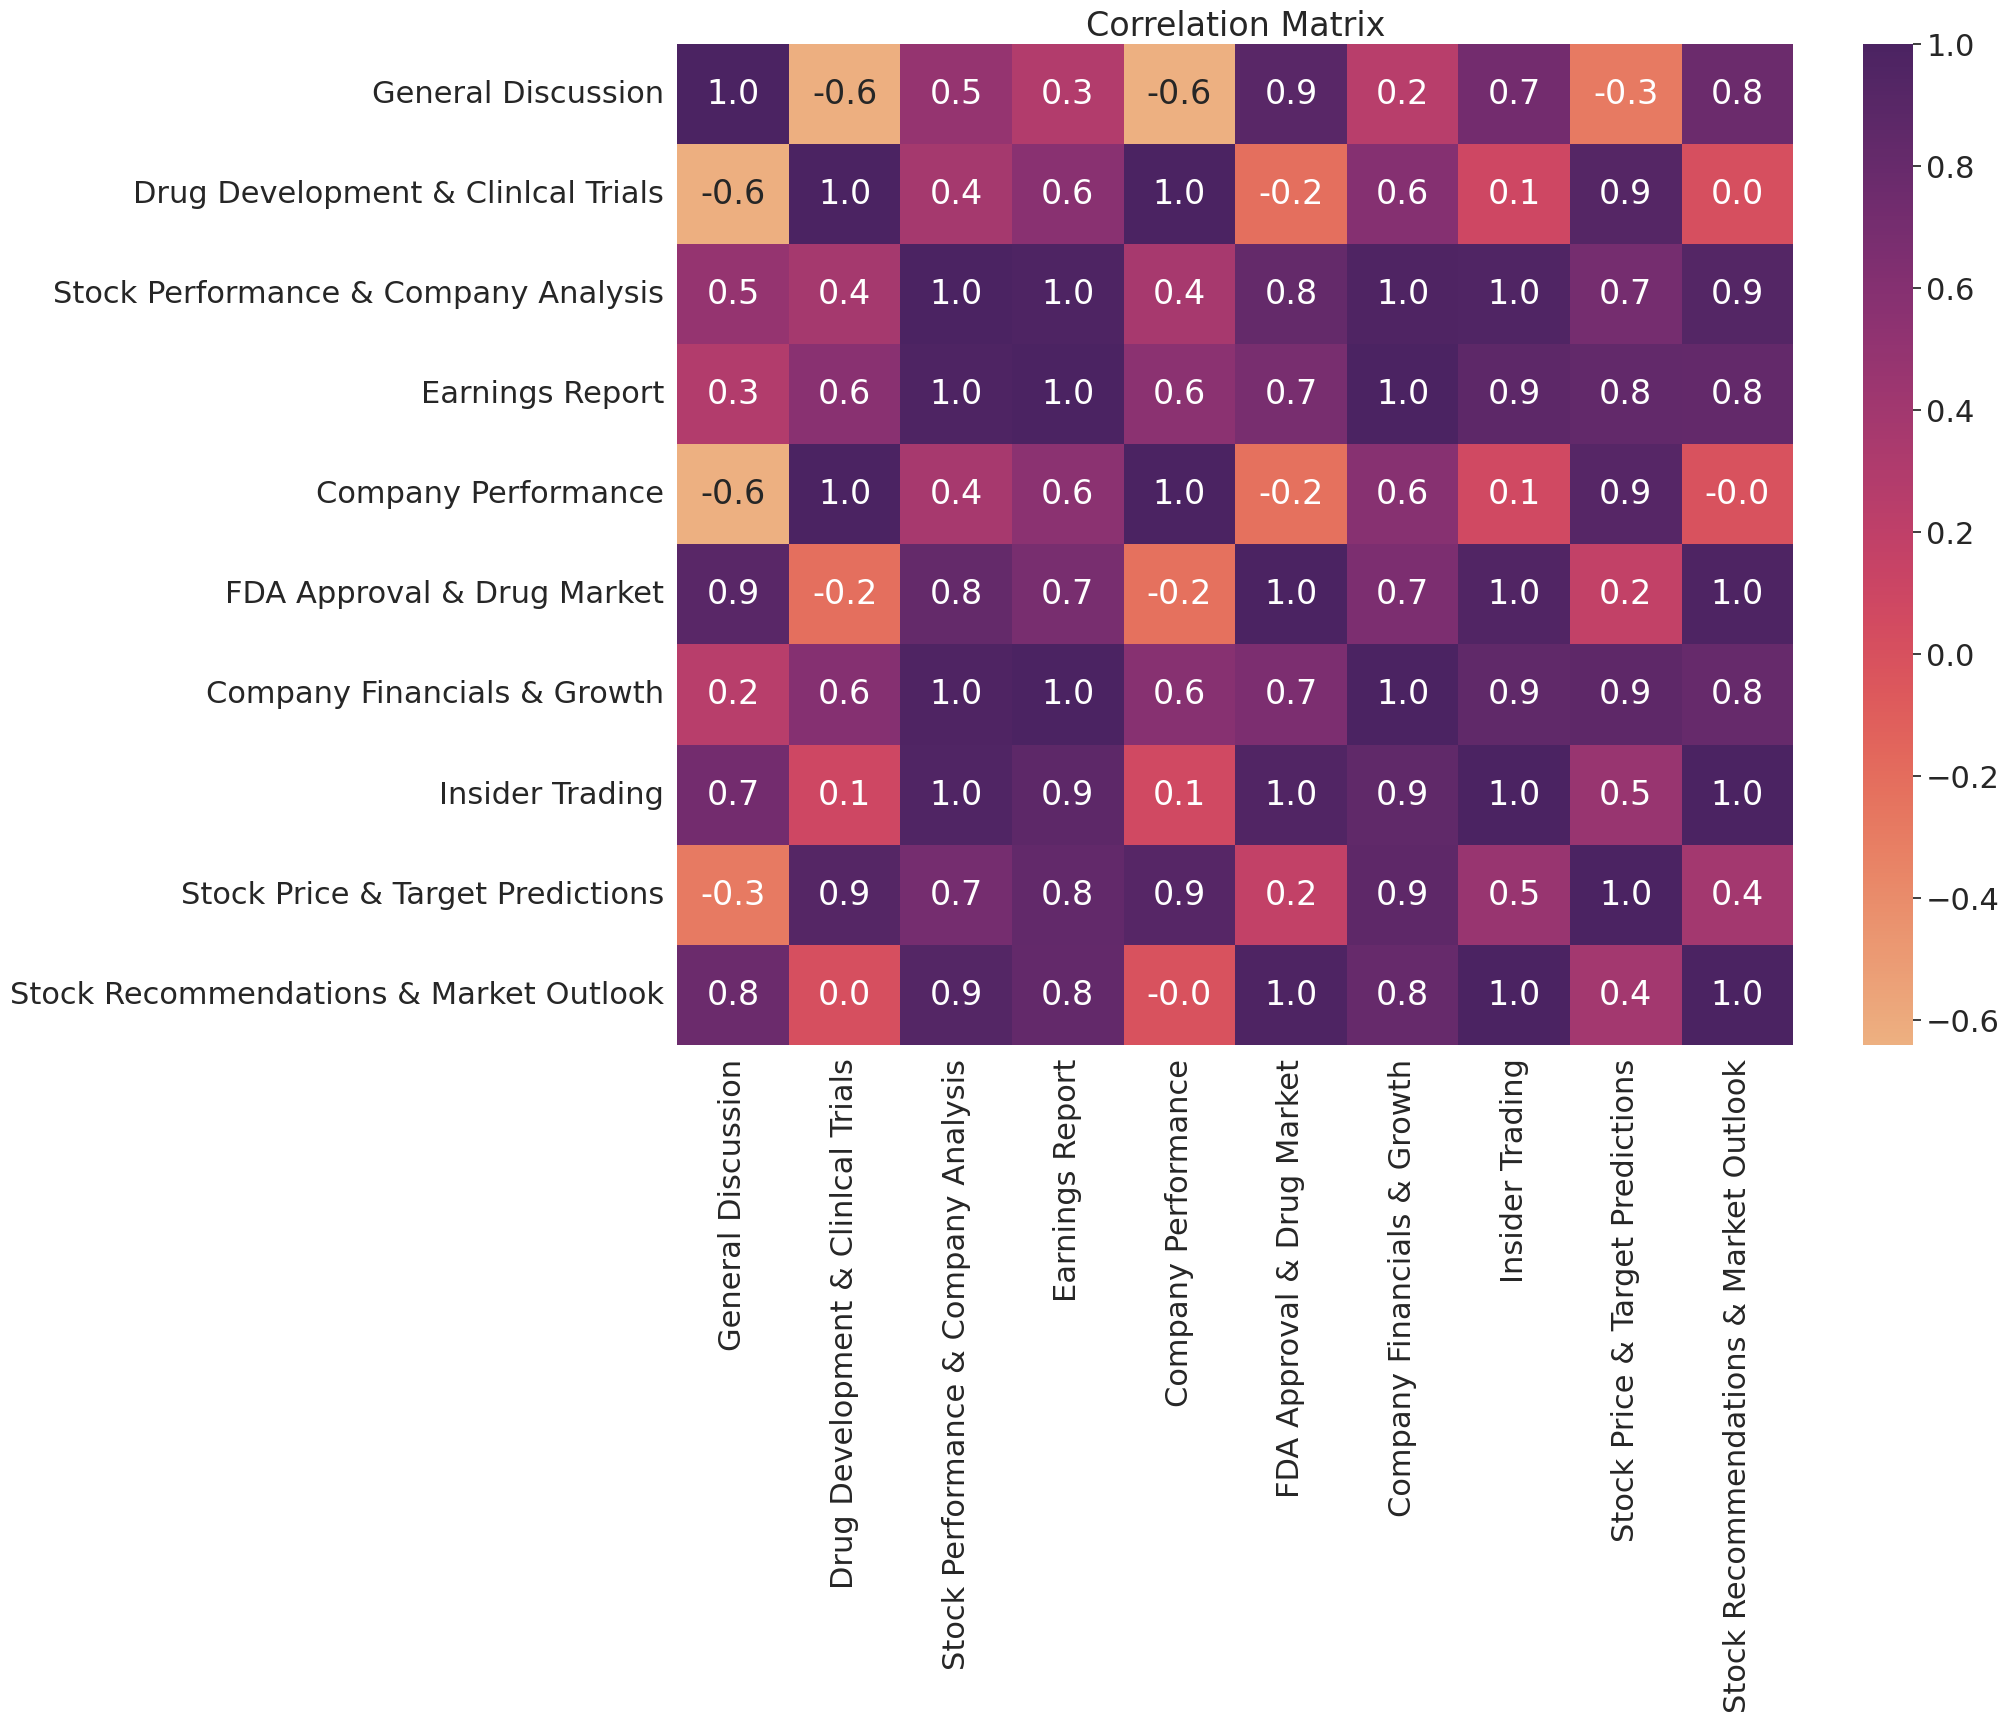

In [113]:
# Define the data
topic_names = [
   'General Discussion',
   'Drug Development & Clinlcal Trials',
   'Stock Performance & Company Analysis',
   'Earnings Report',
   'Company Performance',
   'FDA Approval & Drug Market',
   'Company Financials & Growth',
   'Insider Trading',
   'Stock Price & Target Predictions',
   'Stock Recommendations & Market Outlook']

# Get the topic-polarity matrix
topic_polarity_matrix = df_topic_polarity.values

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(topic_polarity_matrix)
fig, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(correlation_matrix, annot=True, cmap="flare", fmt=".1f", xticklabels=topic_names, yticklabels=topic_names)
plt.title("Correlation Matrix")
plt.show()

###Plot dendongram chart for the topic identified

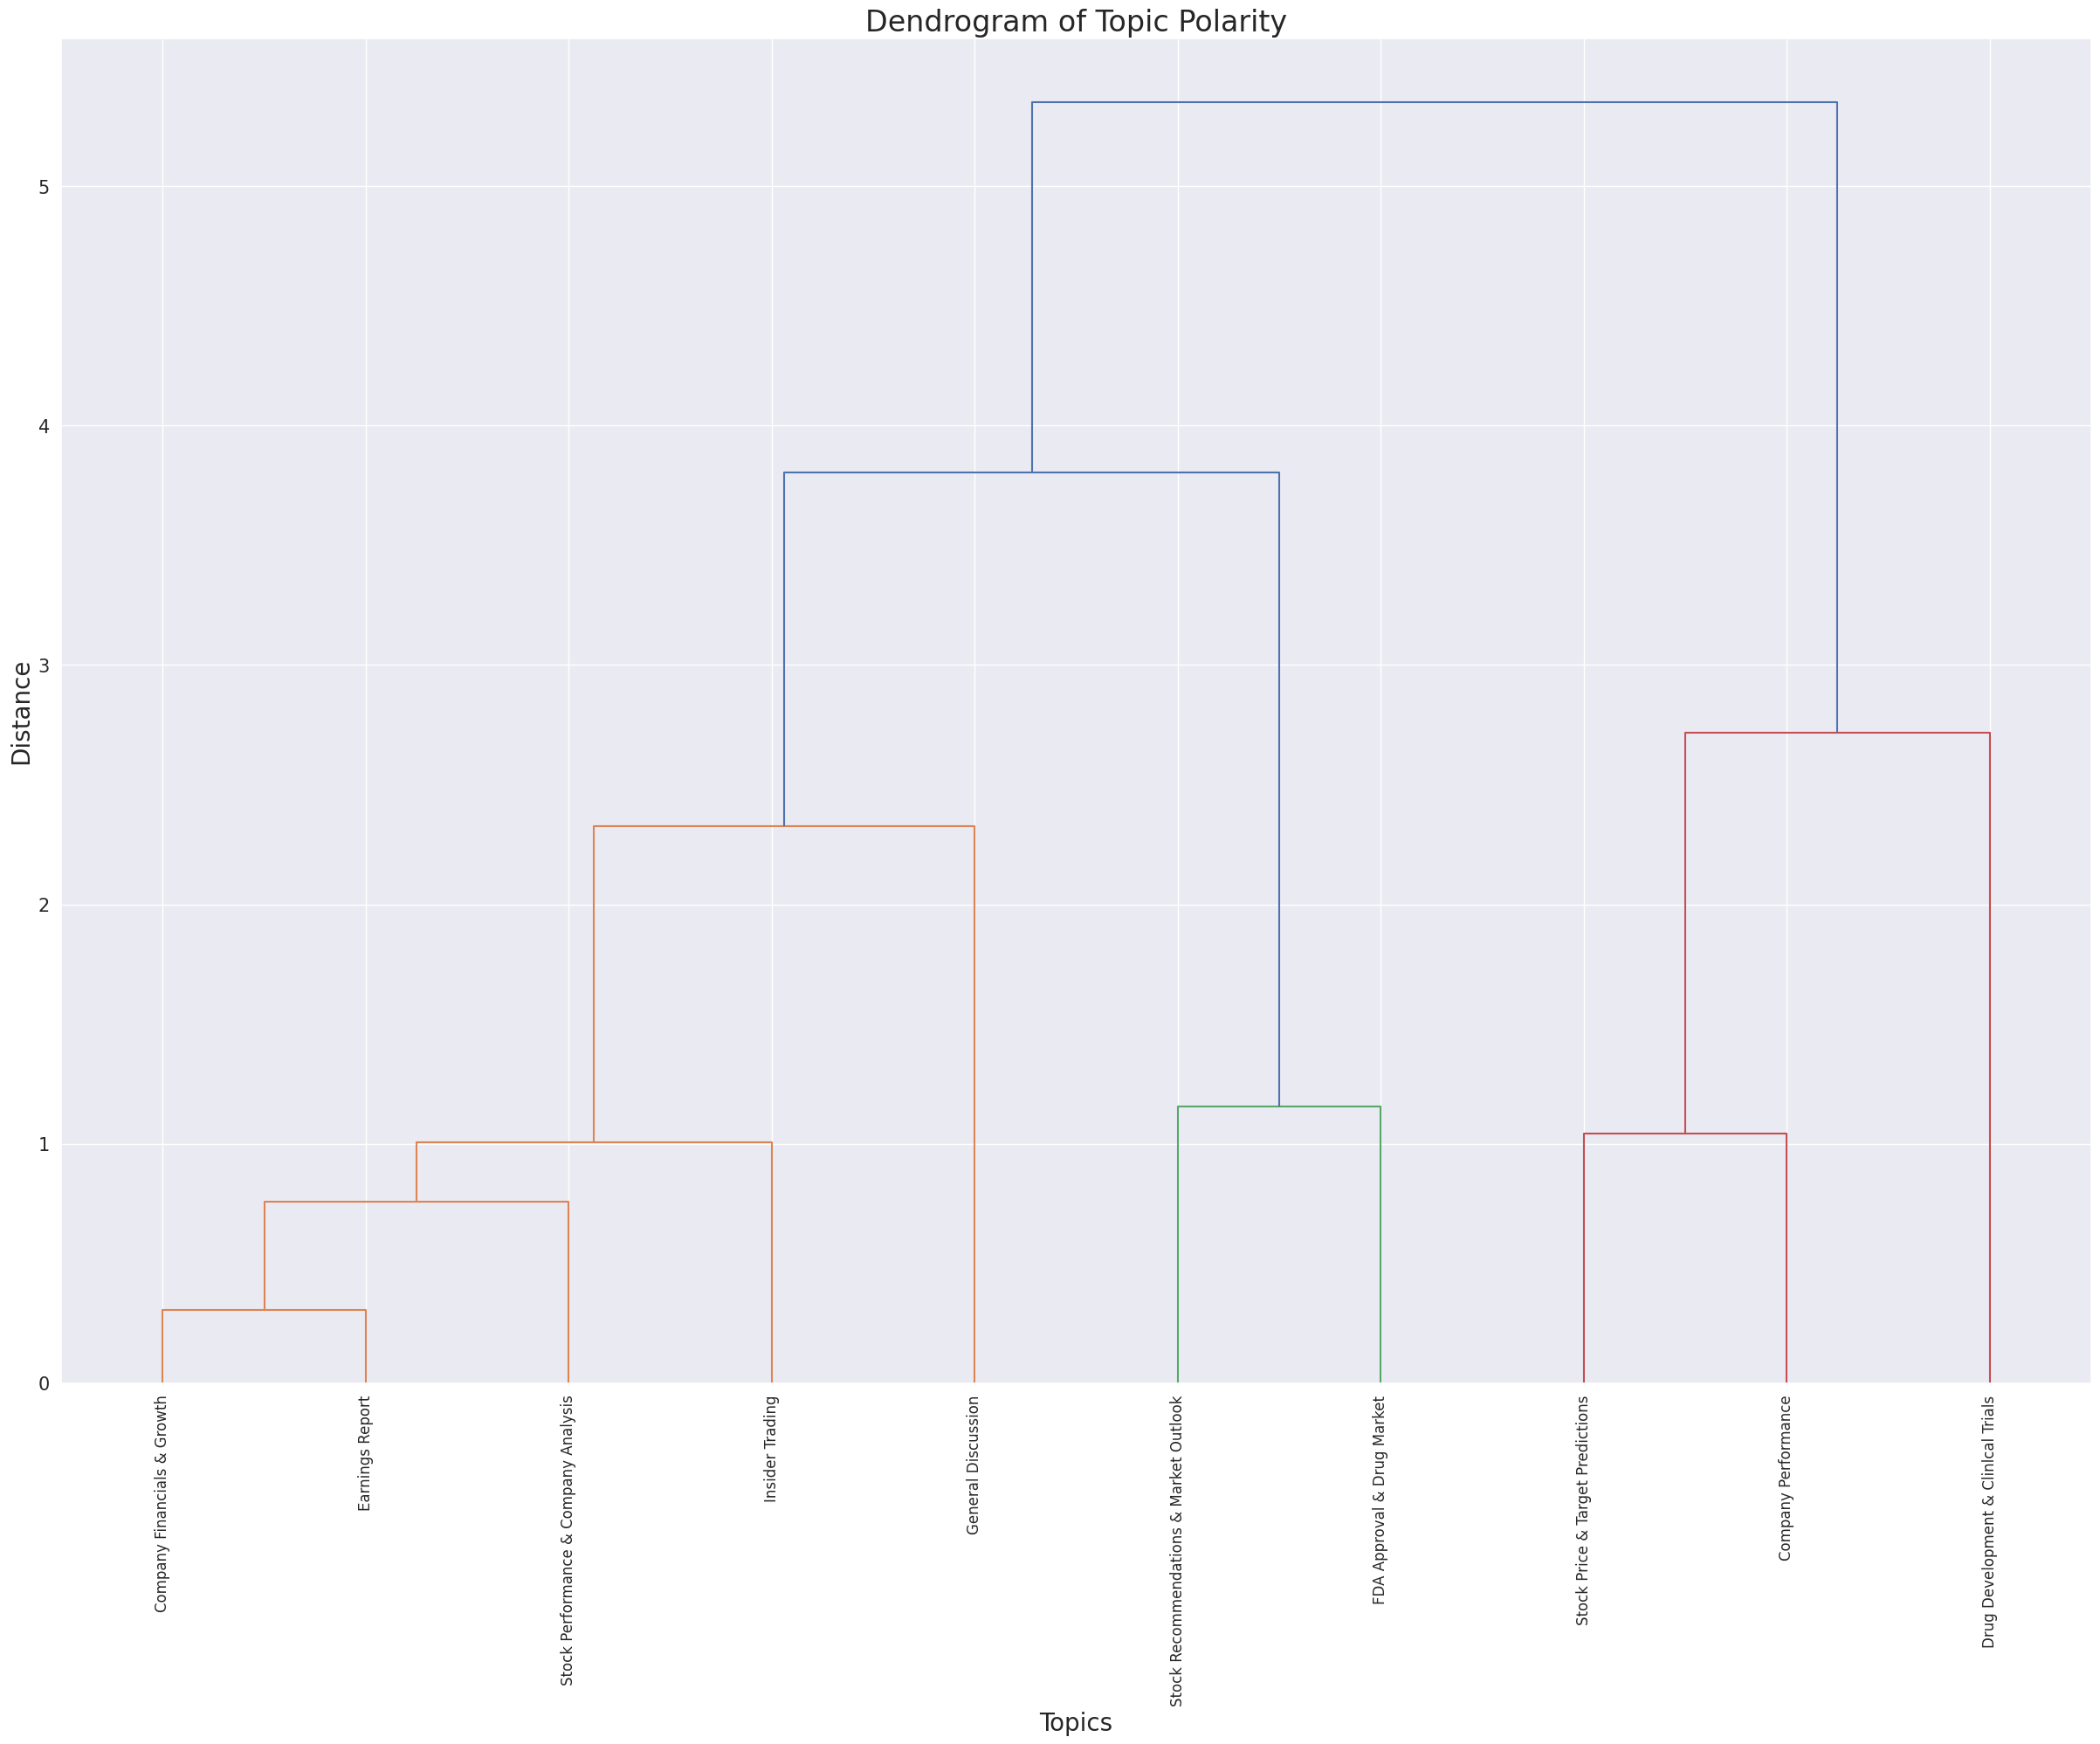

In [114]:

import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler

# Standardize the topic-polarity matrix
scaler = StandardScaler()
scaled_topic_polarity_matrix = scaler.fit_transform(topic_polarity_matrix)

# Calculate the linkage
linkage_matrix = sch.linkage(scaled_topic_polarity_matrix, method='ward')

# Create the dendrogram
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, orientation='top', distance_sort='descending', labels=topic_names)
plt.title('Dendrogram of Topic Polarity', size=24)
plt.xlabel('Topics', size=20)
plt.ylabel('Distance', size=20)
plt.tick_params(axis='x', rotation=90)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()


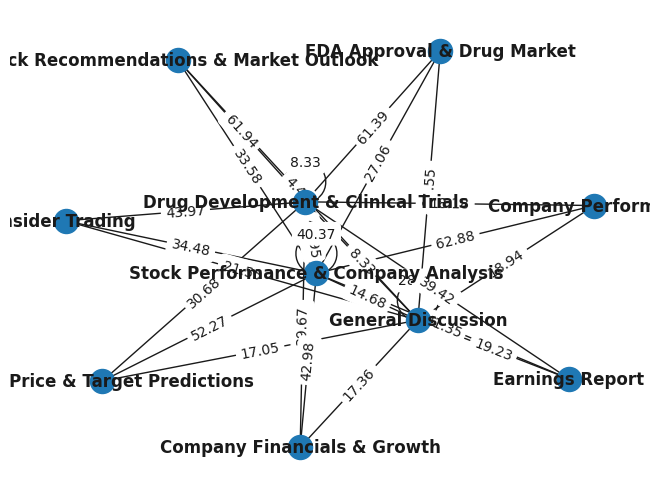

In [115]:
# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(topic_names)

# Add edges to the graph based on the polarity matrix
for i in range(len(topic_polarity_matrix)):
    for j in range(len(topic_polarity_matrix[0])):
        if topic_polarity_matrix[i][j] > 0.5:
            G.add_edge(topic_names[i], topic_names[j], weight=topic_polarity_matrix[i][j])

# Set the layout of the nodes
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, font_weight='bold')

# Set the edge labels
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


###Load libraries for Network Analysis

###Check for the degree of centrality and betweenness for the topics identified

In [116]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Print the results
print("Degree Centrality:")
for node, centrality in degree_centrality.items():
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in betweenness_centrality.items():
    print(f"{node}: {centrality}")


Degree Centrality:
General Discussion: 1.222222222222222
Drug Development & Clinlcal Trials: 1.222222222222222
Stock Performance & Company Analysis: 1.222222222222222
Earnings Report: 0.3333333333333333
Company Performance: 0.3333333333333333
FDA Approval & Drug Market: 0.3333333333333333
Company Financials & Growth: 0.3333333333333333
Insider Trading: 0.3333333333333333
Stock Price & Target Predictions: 0.3333333333333333
Stock Recommendations & Market Outlook: 0.3333333333333333

Betweenness Centrality:
General Discussion: 0.19444444444444442
Drug Development & Clinlcal Trials: 0.19444444444444442
Stock Performance & Company Analysis: 0.19444444444444442
Earnings Report: 0.0
Company Performance: 0.0
FDA Approval & Drug Market: 0.0
Company Financials & Growth: 0.0
Insider Trading: 0.0
Stock Price & Target Predictions: 0.0
Stock Recommendations & Market Outlook: 0.0


In [117]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

# Assuming 'Analysis_Polarity' is your target variable and other relevant features are in X
X = df[['Polarity', 'Subjectivity', 'Topic']]  # Example features, replace with your actual features
y = df['Analysis_Polarity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(gamma='scale')))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))


# Evaluate models
results = []
names = []
for name, model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model: {name}, Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        results.append(accuracy)
        names.append(name)
    except Exception as e:  # Handle potential errors during model training/prediction
        print(f"Error with model {name}: {e}")
        results.append(0)
        names.append(name)


Model: LR, Accuracy: 0.928030303030303
              precision    recall  f1-score   support

    Negative       1.00      0.74      0.85        35
     Neutral       0.89      0.97      0.93       122
    Positive       0.96      0.94      0.95       107

    accuracy                           0.93       264
   macro avg       0.95      0.88      0.91       264
weighted avg       0.93      0.93      0.93       264

Model: KNN, Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

    Negative       0.82      0.94      0.88        35
     Neutral       0.97      0.95      0.96       122
    Positive       0.99      0.97      0.98       107

    accuracy                           0.96       264
   macro avg       0.93      0.96      0.94       264
weighted avg       0.96      0.96      0.96       264

Model: NB, Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

    Negative       1.00      0.69      0.81        35
     Neut

In [118]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

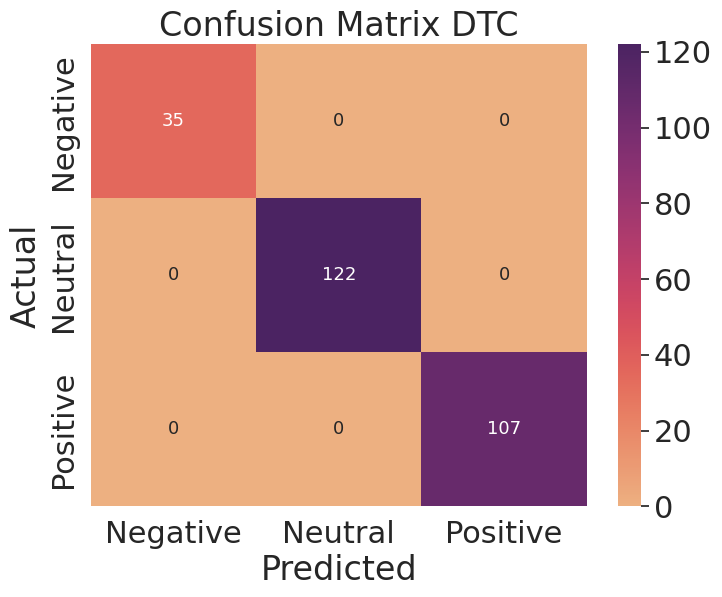

In [119]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            annot_kws={"size": 13})
plt.title("Confusion Matrix DTC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()